# Home Credit - Modelling

In this notebook, we will
1. select an appropriate __evaluation matrix__
2. device our __modelling and validation strategy__
3. select the __best model__ and
4. evaluate __business impact__

We will use the tidy data with newly derived features from the Feature Engineering notebook.

In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from scipy.stats import loguniform

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV


from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

%matplotlib inline
%precision %.2f

plt.style.use('bmh')
pd.set_option('display.max_rows', 30)
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_columns', 100)

# We will work with ~25% data in the process development phase.
process_dev_flag = False
random_seed = 79

In [13]:
train_path = '../data/interim/df_train_fe.csv'
test_path = '../data/interim/df_test_fe.csv'
dtype_path = '../data/interim/data_types_fe.csv'

In [14]:
df_train = pd.read_csv(train_path,index_col=0)
df_test = pd.read_csv(test_path,index_col=0)

df_dtype = pd.read_csv(dtype_path,index_col=0)
dict_dtype = df_dtype.dtype.to_dict()

df_train.shape, df_test.shape

((215249, 188), (92250, 188))

In [15]:
df_train = df_train.astype(dict_dtype)
df_test = df_test.astype(dict_dtype)

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215249 entries, 0 to 215248
Columns: 188 entries, sk_id_curr to total_contact_flags
dtypes: float16(90), float64(28), int64(7), int8(35), object(28)
memory usage: 149.2+ MB


In [17]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92250 entries, 0 to 92249
Columns: 188 entries, sk_id_curr to total_contact_flags
dtypes: float16(90), float64(28), int64(7), int8(35), object(28)
memory usage: 64.0+ MB


In [18]:
df_train.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_2,ext_source_3,basementarea_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingarea_avg,fondkapremont_mode,housetype_mode,wallsmaterial_mode,emergencystate_mode,...,nflag_insured_on_approval_sum,nflag_last_appl_per_contract_sum,nflag_last_appl_in_day_sum,pc_latest_contract_status_last,cr_latest_contract_status_last,name_client_type_last,name_yield_group_grp_mode,name_yield_group_last,name_payment_type_grp_mode,name_payment_type_last,product_combination_last,name_type_suite_last,channel_type_grp_mode,channel_type_last,code_reject_reason_grp_mode,code_reject_reason_last,prev_cnt_ct_cash_loans,prev_cnt_ct_consumer_loans,prev_cnt_ct_revolving_loans,prev_cnt_cs_approved,prev_cnt_cs_canceled,prev_cnt_cs_refused,prev_cnt_cs_unused_offer,prev_cnt_pt_xna,prev_cnt_pt_walk-in,prev_cnt_pt_x-sell,bc_cnt_loans,bc_cnt_credit_type,bc_sum_cnt_credit_prolong,bc_last_days,bc_amt_max_credit_overdue,bb_last_loan_status,bb_cnt_unique_loan_obs,bc_cnt_car_loan,bc_cnt_cr_type_others,bc_cnt_credit_card,bc_cnt_mortgage,bc_cnt_active,bc_cnt_cr_status_others,rt_credit_income,rt_annuity_income,rt_annuity_credit,rt_goods_price_credit,total_document_flags,rt_days_employed_birth,rt_days_id_birth,rt_phone_changed_birth,avg_family_income,avg_family_credit,total_contact_flags
0,389706,0,Revolving loans,0,0,0,2,45000.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.018204,-13349,-2716.0,-3004.0,-4335,NaN,1,0,1,1,0,Sales staff,4.0,3,SATURDAY,12,0,0,0,0,0,0,Self-employed,0.734375,0.667480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,5.0,5.0,Active,NaN,Repeater,high,low_action,Cash through the bank,Cash through the bank,POS household without interest,Unaccompanied,Credit and cash offices,Country-wide,XAP,XAP,2.0,3.0,0.0,4.0,0.0,1.0,0.0,3.0,0.0,2.0,2.0,1.0,0.0,-10.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.000000,0.150000,0.050000,1.000000,0,0.203461,0.324743,0.142183,11250.0,33750.0,3
1,225912,0,Revolving loans,1,0,0,1,103500.0,247500.0,12375.0,247500.0,Unaccompanied,Working,Secondary / secondary special,Widow,Rented apartment,0.020706,-15566,-648.0,-649.0,-4297,NaN,1,0,1,0,0,Laborers,2.0,2,WEDNESDAY,7,0,0,0,0,0,0,Industry: type 7,0.544922,0.845215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,Completed,NaN,New,low_normal,low_normal,Cash through the bank,Cash through the bank,POS mobile without interest,NaN,Country-wide,Country-wide,XAP,XAP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,2.0,1.0,-6.0,0.0,NaN,0.0,0.0,0.0,4.0,0.0,3.0,0.0,2.391304,0.119565,0.050000,1.000000,0,0.041629,0.276050,0.027303,51750.0,123750.0,2
2,405407,0,Revolving loans,1,0,1,0,90000.0,135000.0,6750.0,135000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.025162,-14437,-352.0,-786.0,-5261,NaN,1,0,1,0,0,High skill tech staff,1.0,2,SUNDAY,9,0,0,0,0,0,0,Business Entity Type 2,0.197510,NaN,0.059998,0.333252,0.375,0.0,0.102173,not specified,block of flats,"Stone, brick",No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,0.0,-1629.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.500000,0.075000,0.050000,1.000000,0,0.024382,0.364411,0.013091,90000.0,135000.0,2
3,172092,0,Cash loans,1,0,0,0,121500.0,254700.0,26874.0,225000.0,Unaccompanied,Working,

Getting the list of categorical features with more than 2 levels.

In [19]:
cat_object_var_path = '../data/interim/cat_encode_features.csv'
df_cat_object = pd.read_csv(cat_object_var_path,index_col=0)
cat_object_features = list(df_cat_object.cat_object)
len(cat_object_features)

28

Getting the list of categorical features with just 2 levels. These features are stored as integers.

In [20]:
cat_bin_path = '../data/interim/cat_bin_num_features.csv'
df_cat_bin_num = pd.read_csv(cat_bin_path,index_col=0)
cat_bin_num_features = list(df_cat_bin_num.cat_bin_num)
len(cat_bin_num_features)

34

Finally, remaining features are numerical

In [21]:
num_features = set(df_train.columns) - (set(cat_object_features) | set(cat_bin_num_features))
num_features = list(num_features)
num_features.remove('sk_id_curr')
num_features.remove('target')
print(len(num_features))

124


## Evaluation matrix

For Home Credit, it is equally important to  

1. Avoid customers who are likely to default on the loan and
2. Increase customers who are likely to pay back the loan

Given this business objective, we will be __using the roc_auc__ matrix as it considers both the classes(default/no default). 
The pr_auc matrix mainly cares about positive class(default). Hence, we will avoid it.

## Modelling Strategy

We consider following algorithms for our classification task.

1. __Logistic Regression with l1 regularization__ - Logistic regression is a simple linear algorith with descent performance. As we have 180+ features and many are correlated features, we will use l1 regularization for feature selection. 
2. __XgBoost__ - XgBoost 
3. __LightGBM__ - LightGBM 

### Handling missing values
1. __Categorical__ features - Create a seperate nan category/level for missing value. We will do this at the time of one-hot-encoding using pandas get_dummy function.
2. __Numerical__ features - For logistic regression, we will impute missing values with median because numerical features are highly skewed as observed in EDA. XgBoost & LightGBM can handle missing in a supervised way to optimize perfromance. Hence, we will not impute numerical features for these two algorithms. 


#### Creating dummy variables

In [11]:
df_train_dummies = pd.get_dummies(df_train,columns = cat_object_features, dummy_na=True)
df_test_dummies = pd.get_dummies(df_test,columns = cat_object_features, dummy_na=True)

Aligning test data with train data so that it has same feaures.

In [12]:
#source : https://kanoki.org/2019/08/27/pandas-dataframe-align-function/
df_train_dummies, df_test_dummies = df_train_dummies.align(df_test_dummies, join = 'left', axis = 1)
df_train_dummies.shape, df_test_dummies.shape

((215249, 423), (92250, 423))

In [13]:
new_features = [ col for col in df_train_dummies.columns if col not in df_train.columns]

In [14]:
X_train = df_train_dummies.drop(columns=['target','sk_id_curr'])
y_train = df_train_dummies.target

if process_dev_flag == True :
    records = 50000
    X_train = X_train[:records]
    y_train = y_train[:records]

X_test = df_test_dummies.drop(columns=['target','sk_id_curr'])
y_test = df_test_dummies.target

## Validation Strategy

We will use __5-fold__ cross-validation strategy on train data for model tunning and modle selection. We will train these 3 models on same set train-validation datasets. To select best hyperparameters, we will use __RandomSearchCV__ technique.  


And finally, we will test the performance of the best model on test dataset.

In [15]:
num_folds = 5
cv = KFold(n_splits= num_folds, shuffle=True, random_state=random_seed)

### Logistic regression 
We will use median imputation to fill missing values for numerical features using column transformer. As we are using l1 regularization and for greater convergence speed, we will scale these features using StandardScaler.

We will tune C (regularization) parameter using RandomSearchCV.

In [ ]:
numeric_transformer = Pipeline(steps=[
                                ('imputer', SimpleImputer(strategy="median")),
                                ('scaler',StandardScaler())])

preprocessor = ColumnTransformer( 
                    transformers=[('num', numeric_transformer, num_features)], 
                    remainder = 'passthrough',
                    sparse_threshold=0 ) # to get the dense matrix

# saga works with l1 penalty and tol is set to 1e-2 for faster convergence
classifier_lr = LogisticRegression(penalty='l1', solver = 'saga', 
                                   max_iter=500, tol = 1e-2, 
                                   random_state=random_seed)

clf_lr = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('classifier_lr', classifier_lr)])

param_dists = { 'classifier_lr__C': loguniform(1e-2, 1e2) }
iterations = 10

In [ ]:
%%time
cv_lr = RandomizedSearchCV(clf_lr, 
                           param_distributions=param_dists, 
                           scoring = 'roc_auc',
                           n_iter=iterations, 
                           cv=cv, 
                           n_jobs= -2,
                           random_state = random_seed)

cv_lr.fit(X_train, y_train)

In [ ]:
cv_lr_results = pd.DataFrame(cv_lr.cv_results_)

In [16]:
# modified from https://inria.github.io
def shorten_param_names_pipeline(param_name):
    """
    Shorten the hyperparameter names from CrossValidation results of pipeline.
    
    Keyword arguments:
    param_name -- column name of cv_results_ dataframe
    """
    
    if '__' in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

def shorten_param_names(param_name):
    """
    Shorten the hyperparameter names from CrossValidation results of model.
    
    Keyword arguments:
    param_name -- column name of cv_results_ dataframe
    """
    
    if 'param_' in param_name:
        return param_name.replace("param_", "")
    return param_name

In [20]:
# to get only the parameters columns
col_results = column_results = ['param_{}'.format(name) for name in param_dists.keys()]

# add score columns
column_results += ['mean_test_score', 'std_test_score', 'rank_test_score']

cv_lr_results = cv_lr_results[column_results].sort_values(
                            'mean_test_score', ascending=False)

cv_lr_results.columns = [shorten_param_names_pipeline(col) for col in cv_lr_results.columns]
cv_lr_results

NameError: name 'param_dists' is not defined

In [20]:
gpu_params = {'tree_method':'gpu_hist', 
              'predictor':'gpu_predictor',
              'n_jobs': -1}

xgb_clf = xgb.XGBClassifier(objective= 'binary:logistic', max_delta_step = 1,
                             **gpu_params, use_label_encoder=False, 
                            seed=random_seed)

xgb_param_dists = {'learning_rate': loguniform(0.001, 1),
               'max_depth' : [1,4,8,16],
               'min_child_weight' : [1,4,8],
               'colsample_bytree' : [0.6,0.8],
               'subsample' : [0.6,0.8],
               'n_estimators' : [200,400,800,1600],
               'reg_alpha' : loguniform(0.001, 10) }

xgb_iterations = 1

In [24]:
%%time
xgb_cv = RandomizedSearchCV(xgb_clf, 
                           param_distributions=xgb_param_dists, 
                           scoring = 'roc_auc',
                           n_iter=xgb_iterations, 
                           cv=cv, 
                           random_state = random_seed)

xgb_cv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[10:12:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:17:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:21:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 22.8min finished


[10:35:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 28min 7s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=79, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None, max_delta_step=1,
                                           max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           m...
                   param_distributions={'colsample_bytree': [0.6, 0.8],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F836FE4988>,
                  

In [25]:
xgb_cv_results = pd.DataFrame(xgb_cv.cv_results_)

# to get only the parameters columns
col_results = column_results = ['param_{}'.format(name) for name in xgb_param_dists.keys()]

# add score columns
column_results += ['mean_test_score', 'std_test_score', 'rank_test_score']

xgb_cv_results = xgb_cv_results[column_results].sort_values(
                            'mean_test_score', ascending=False)

xgb_cv_results.columns = [shorten_param_names(col) for col in xgb_cv_results.columns]
xgb_cv_results

,learning_rate,max_depth,min_child_weight,colsample_bytree,subsample,n_estimators,reg_alpha,mean_test_score,std_test_score,rank_test_score
0,0.015786,16,1,0.8,0.8,200,0.003951,0.760611,0.005622,1


In [17]:
X_col_names = X_train.columns

In [18]:
lgb_clf = lgb.LGBMClassifier(objective= 'binary',
                            random_state =random_seed)


lgb_param_dists = {
            'learning_rate': loguniform(0.01, 1),
            'n_estimators': [200,400,800,1600,6400],
            'num_leaves': [4,8,16,50],
            'min_child_weight' : [1,4,8,16],
            'colsample_bytree' : [0.6,0.8],
            'subsample' : [0.6,0.8,1],
            'reg_alpha': loguniform(0.001, 1)}

lgb_iterations = 5

In [19]:
%%time
lgb_cv = RandomizedSearchCV(lgb_clf, 
                           param_distributions=lgb_param_dists, 
                           scoring = 'roc_auc',
                           n_iter=lgb_iterations, 
                           cv=cv, 
                           n_jobs= -2,
                           verbose = 2,
                           random_state = random_seed)

import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
lgb_cv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  17 out of  25 | elapsed: 39.3min remaining: 18.5min
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed: 51.8min finished


Wall time: 52min 56s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=79, shuffle=True),
                   estimator=LGBMClassifier(objective='binary',
                                            random_state=79),
                   n_iter=5, n_jobs=-2,
                   param_distributions={'colsample_bytree': [0.6, 0.8],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024F241FBD08>,
                                        'min_child_weight': [1, 4, 8, 16],
                                        'n_estimators': [200, 400, 800, 1600,
                                                         6400],
                                        'num_leaves': [4, 8, 16, 50],
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024F241FB988>,
                                        'subsample': [0.6, 0.8, 1]},
                   random_state=79, scoring='roc_auc', verbose=2)

In [20]:
lgb_cv_results = pd.DataFrame(lgb_cv.cv_results_)

# to get only the parameters columns
col_results = column_results = ['param_{}'.format(name) for name in lgb_param_dists.keys()]

# add score columns
column_results += ['mean_test_score', 'std_test_score', 'rank_test_score']

lgb_cv_results = lgb_cv_results[column_results].sort_values(
                            'mean_test_score', ascending=False)

lgb_cv_results.columns = [shorten_param_names(col) for col in lgb_cv_results.columns]
lgb_cv_results

,learning_rate,n_estimators,num_leaves,min_child_weight,colsample_bytree,subsample,reg_alpha,mean_test_score,std_test_score,rank_test_score
1,0.043927,1600,16,8,0.8,1,0.001525,0.778719,0.005248,1
0,0.062928,6400,4,16,0.8,0.8,0.002802,0.777191,0.004555,2
4,0.025446,1600,4,16,0.8,1,0.007874,0.776866,0.006033,3
2,0.014464,6400,50,8,0.8,0.6,0.23987,0.772392,0.004955,4
3,0.132175,6400,50,16,0.8,0.6,0.010544,0.744030,0.004239,5


In [21]:
lgb_cv.best_params_

{'colsample_bytree': 0.80,
 'learning_rate': 0.0439266479272964,
 'min_child_weight': 8,
 'n_estimators': 1600,
 'num_leaves': 16,
 'reg_alpha': 0.0015249981951798595,
 'subsample': 1}

In [22]:
best_model = lgb_cv.best_estimator_

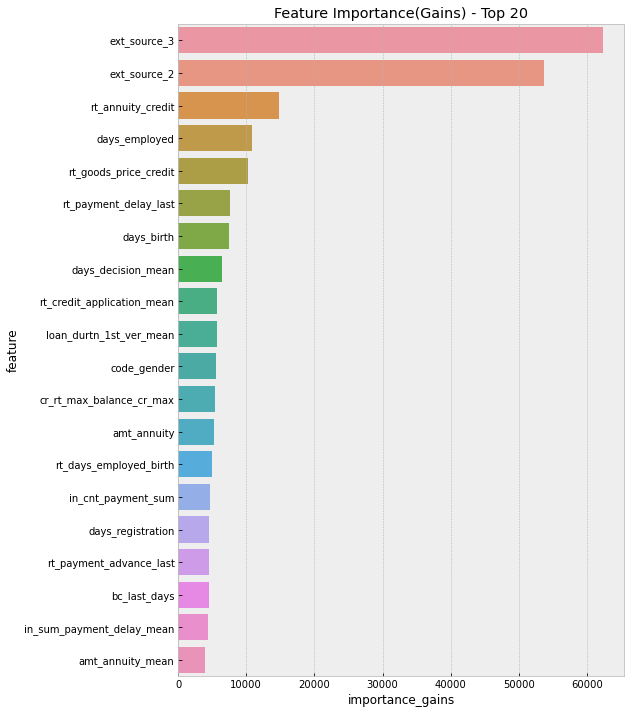

In [23]:
df_feature_imp = pd.DataFrame(X_train.columns,columns=['feature'])
df_feature_imp['importance_gains'] = best_model.booster_.feature_importance(importance_type='gain')
df_feature_imp['importance_split'] = best_model.booster_.feature_importance(importance_type='split')

df_feature_imp.sort_values(by='importance_gains', ascending=False, inplace=True)
df_featture_imp_top = df_feature_imp.head(20)

fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(x ='importance_gains', y='feature', data = df_featture_imp_top)
plt.title('Feature Importance(Gains) - Top 20')
plt.show()

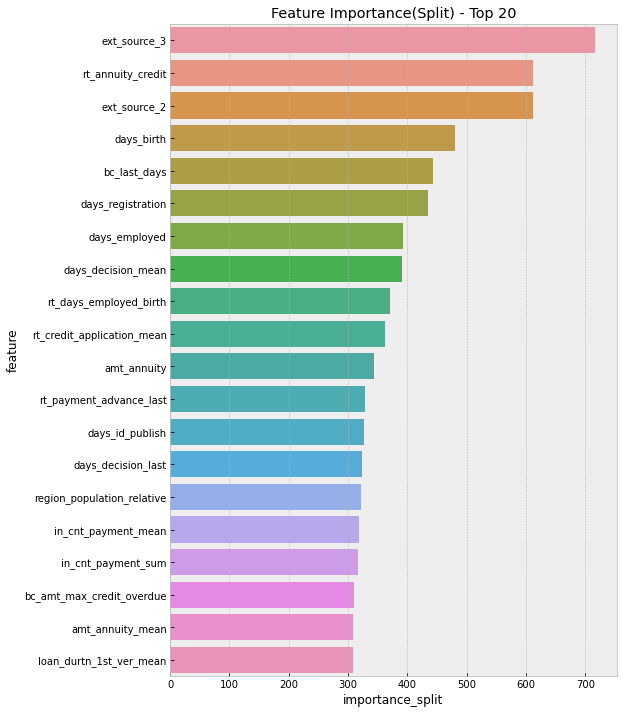

In [24]:
df_feature_imp.sort_values(by='importance_split', ascending=False, inplace=True)
df_featture_imp_top = df_feature_imp.head(20)

fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(x ='importance_split', y='feature', data = df_featture_imp_top)
plt.title('Feature Importance(Split) - Top 20')
plt.show()

In [25]:
y_pred_probs = best_model.predict_proba(X_test)[:,1]
roc_auc_score(y_test.values, y_pred_probs)

0.7824892779239774

In [26]:
fpr, tpr, thresholds = roc_curve(y_test.values, y_pred_probs)

In [27]:
# To get the best threshold, we will use J statistics
# source : https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
j_stat = tpr - fpr
ix = np.argmax(j_stat)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.074195


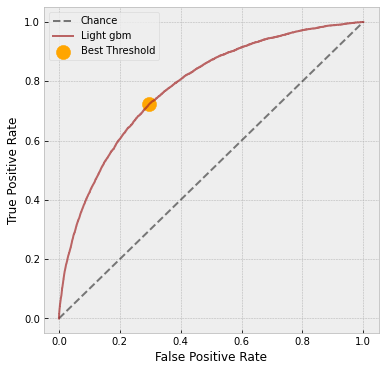

In [28]:
# plot the roc curve for the model
fig, ax = plt.subplots(figsize=(6,6))
plt.plot([0,1], [0,1], linestyle='--', label='Chance', color='k', alpha= 0.5)
plt.plot(fpr, tpr, linestyle='-',label='Light gbm', color='brown', alpha= 0.7)
plt.scatter(fpr[ix], tpr[ix], marker='o', s=200, color='orange', label='Best Threshold')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [29]:
# Corresponding fpr & tpr
print('Best Threshold: {}'.format(round(best_thresh,4)))
print('Corresponding fpr : {} and tpr: {}'.format(round(fpr[ix],4), round(tpr[ix],4)))

Best Threshold: 0.0742
Corresponding fpr : 0.2972 and tpr: 0.7237


In [30]:
def get_confusion_matrix(y_probabilities, y_true, threshold):
    """
    Get the confusion matrix using specified threshold
    
    Keyword arguments:
    y_probabilities -- predicted probabilities of positive class
    y_true -- true value of y
    threshold -- threshold to use to get 0/1 prediction
    
    Returns :
    2*2 confusion_matrix
    """
    y_pred = np.zeros(y_true.shape)
    y_pred = np.where( y_probabilities > threshold ,1, 0 )
    return confusion_matrix(y_test, y_pred)

conf_matx = get_confusion_matrix(y_pred_probs, y_test, best_thresh)

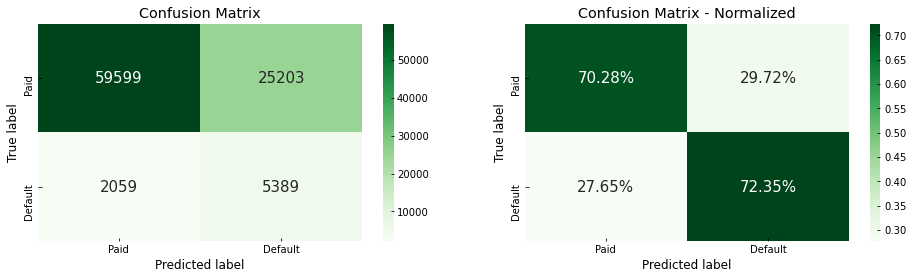

In [93]:
def custom_plot_confusion_matrix(confusion_matrix_array):
    """
    Plot the confusion matrix
    
    Keyword arguments:
    confusion_matrix -- 2*2 confusion matrix
    """
    
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    display_labels = ['Paid', 'Default']
    sns.heatmap(confusion_matrix_array, xticklabels = display_labels, yticklabels = display_labels, 
                annot=True, cmap='Greens', fmt='d', annot_kws={"size": 15}, ax=ax[0])
    ax[0].set_ylabel('True label')
    ax[0].set_xlabel('Predicted label')
    ax[0].set_title('Confusion Matrix')
    
    confusion_matrix_norm = confusion_matrix_array/confusion_matrix_array.sum(axis=1).reshape(-1,1)
    sns.heatmap(confusion_matrix_norm, xticklabels = display_labels, yticklabels = display_labels, 
                annot=True, cmap='Greens', fmt=".2%", annot_kws={"size": 15}, ax=ax[1])
    ax[1].set_ylabel('True label')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_title('Confusion Matrix - Normalized')
    
    
custom_plot_confusion_matrix(conf_matx)

In [84]:
mean_credit_paid = df_test.loc[df_test.target==0, ].amt_credit.mean()
mean_credit_default = df_test.loc[df_test.target==1, ].amt_credit.mean()
mean_credit_paid,mean_credit_default

(601969.81, 554235.12)

In [85]:
profit_on_paid_loans = 0.05
loss_on_default_loans = 0.40

class cls_business_params:
    """
    Class to store business information regarding loan size, profit/loss
    set_business_params - to set the values of business parameters
    get_business_params - to get the values of business parameters
    """

    def __init__(self,mean_credit_paid,mean_credit_default,profit_on_paid_loans,loss_on_default_loans): 
        # instance as passed as a first agrument. Referred as self
        self.mean_credit_paid = mean_credit_paid
        self.mean_credit_default = mean_credit_default
        self.profit_on_paid_loans = profit_on_paid_loans
        self.loss_on_default_loans = loss_on_default_loans
        
    def set_business_params(mean_credit_paid,mean_credit_default,profit_on_paid_loans,loss_on_default_loans):
        self.mean_credit_paid = mean_credit_paid
        self.mean_credit_default = mean_credit_default
        self.profit_on_paid_loans = profit_on_paid_loans
        self.loss_on_default_loans = loss_on_default_loans        
    
    def get_business_params(self):
        return mean_credit_paid, mean_credit_default, profit_on_paid_loans, loss_on_default_loans
    
business_params = cls_business_params(mean_credit_paid,mean_credit_default,profit_on_paid_loans,loss_on_default_loans)

In [86]:
def calculate_expectancy(confusion_matrix_array, business_params):
    """
    Calculates  business expectancy/profit 
    
    Keyword arguments:
    confusion_matrix -- to set the values of business parameters
    business_params -- instance of  business_params containing profit,/loss, loan size values
    Returns :
    expectancy -- profit/loss based on confusion matrix and business parameters
    """
    tn, fp, fn, tp = confusion_matrix_array.flatten()
    mean_credit_paid, mean_credit_default, profit_on_paid_loans, loss_on_default_loans = business_params.get_business_params()

    expectancy = (tn * mean_credit_paid * profit_on_paid_loans         # profit from fully paid loans
                + tp * mean_credit_default * loss_on_default_loans     # notional profit from avoiding defaults 
                - fp * mean_credit_paid * profit_on_paid_loans         # notional loss from avoiding potentially paid back loans
                - fn * mean_credit_default * loss_on_default_loans)    # loss from deafults on loans

    return expectancy

In [133]:
def plot_profitability_curve(y_probabilities, y_true, business_params):
    """
    Plots profit against thresholds for positive class
    
    Keyword arguments:
    y_probabilities -- predicted probabilities of positive class
    y_true -- true value of y
    business_params -- instance of  business_params containing profit,/loss, loan size values
    Returns :
    max_profit -- maximum profit achievable with business constraints and model capabilities
    max_profit_threshold -- positive class threshold associated with maximum profit
    """

    thresholds = np.linspace(0,1,30)
    expectancy = []
    for threshold in thresholds:
        conf_matx = get_confusion_matrix(y_probabilities, y_true, threshold)
        expt = calculate_expectancy(conf_matx, business_params)
        expectancy.append(expt)
    
    idx = np.argmax(expectancy)
    max_profit = np.max(expectancy)
    max_profit_threshold = thresholds[idx]

    fig, ax = plt.subplots(figsize=(7,5))
    plt.plot(thresholds, expectancy, linestyle='-',label='profit', color='brown', alpha= 0.7)
    #plt.scatter(max_profit_threshold, max_profit, marker='o', s=200, color='orange', label='Best Threshold')
    max_profit_fmt = 'profit: {0:.1f} billion'.format(max_profit/1e9)
    max_profit_fmt  
    ax.annotate(max_profit_fmt, xy=(max_profit_threshold, max_profit),  xycoords='data',
            xytext=(0.5, 0.9), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            fontsize=12)
    
    plt.xlabel('Thresholds')
    plt.ylabel('Profits')
    plt.legend()
    plt.title('Profitability Curve')
    plt.show()
    
    return max_profit, max_profit_threshold

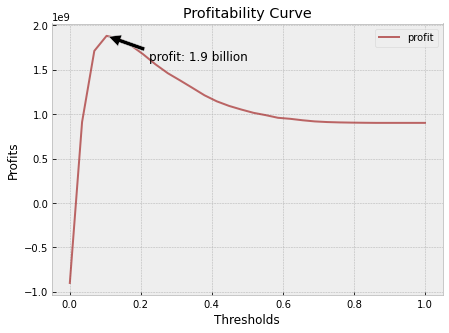

In [134]:
max_profit, max_profit_threshold = plot_profitability_curve(y_pred_probs, y_test, business_params)

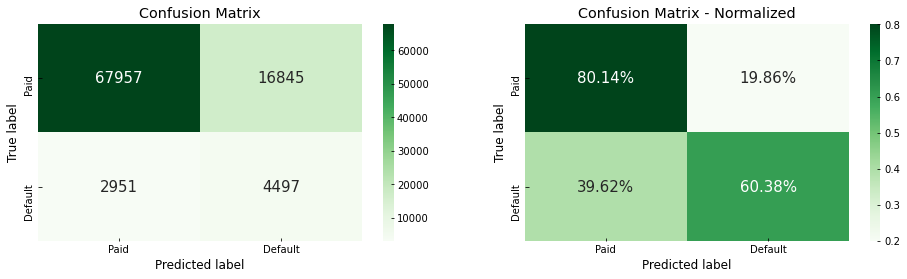

In [135]:
max_profit_conf_matx = get_confusion_matrix(y_pred_probs, y_test, max_profit_threshold)
custom_plot_confusion_matrix(max_profit_conf_matx)

Profit Maximizing Threshold: 0.1034
Corresponding Profit : 1881133042


In [ ]:
Add classification report,

In [5]:
x = 0.781403 + 0.004963
print(x)

0.786366


In [8]:
df = pd.DataFrame(['gender','income'],columns=['col'])
df_2 = pd.DataFrame(['gender','occupation'],columns=['col'])
set(df.col) & set(df_2.col)

In [23]:
df_train.loan_durtn_1st_ver_mean.isna().mean()

0.06769834006197474

In [24]:
1.9*1e9/df_test.amt_credit.sum()

0.03443514502411063

In [26]:
x = 0.7814 + 0.0047
y = 0.7814 - 0.0047
print(x,y)

0.7861 0.7767


In [29]:
cnt_default = df_test.target.sum()
cnt_paid = df_test.shape[0] - cnt_default
cnt_default,cnt_paid

(7448, 84802)

In [30]:
cnt_paid*0.5*601969.81 - cnt_default*0.4*554235.12

23872944644.306

change in tolerance : 
https://stats.stackexchange.com/questions/255375/what-exactly-is-tol-tolerance-used-as-stopping-criteria-in-sklearn-models

max_delta_step : xgboost document, for imbalanced class convergence
https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html

auc_roc : 
https://www.kaggle.com/c/ieee-fraud-detection/discussion/99982  
https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

comparison of roc & pr curve - imbalanced data
https://sinyi-chou.github.io/classification-pr-curve/

https://www.ritchieng.com/machine-learning-evaluate-classification-model/

pr_auc
https://sinyi-chou.github.io/python-sklearn-precision-recall/  
https://sanchom.wordpress.com/tag/average-precision/   
https://medium.com/analytics-vidhya/precision-recall-tradeoff-for-real-world-use-cases-c6de4fabbcd0   

More on roc :
https://community.tibco.com/wiki/gains-vs-roc-curves-do-you-understand-difference

probabilistic interpretation of roc
https://madrury.github.io/jekyll/update/statistics/2017/06/21/auc-proof.html

Profitability curve :
https://community.datarobot.com/t5/resources/describing-and-evaluating-models/ta-p/1491

Evaluating Classifiers
https://www.svds.com/classifiers2/   
https://www.svds.com/evaluating-data-science-projects/    
